In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [278]:
arrests_df = pd.read_csv("data/UsArrests.csv")

In [279]:
arrests_df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60


In [280]:
# Rename city column to state
arrests_df.rename(columns={"City": "State"}, inplace=True)

In [281]:
print(f"Number of States:\t{arrests_df.shape[0]}\nNumber of Features:\t{arrests_df.shape[1] - 1}")

Number of States:	50
Number of Features:	4


In [282]:
missing = pd.DataFrame(arrests_df.isnull().sum(), columns=["missing"])
missing

,missing
State,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [283]:
# Set the decimal precision to 3
pd.set_option("display.float_format", lambda x: "%.2f" % x)

stats = arrests_df.describe()
chosen_stats = stats.loc[["mean", "std", "min", "max"]].T
chosen_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


In [284]:
arrests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


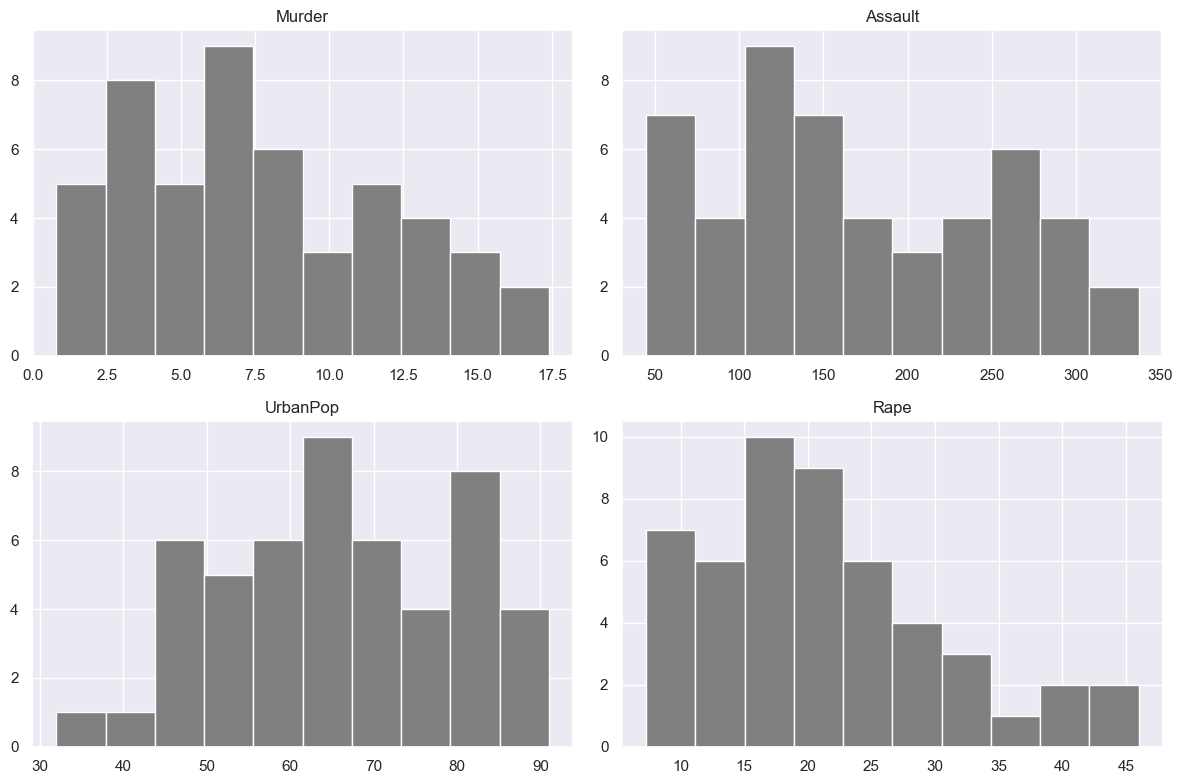

In [285]:
sns.set_theme(style="darkgrid")
histograms = arrests_df.hist(color="gray", figsize=(12, 8))
plt.tight_layout()
plt.show()

# TODO: Make these better


In [286]:
frames = [missing, chosen_stats]
summary = pd.concat(frames, axis=1)

summary.to_csv("data/summary.csv")

summary

,missing,mean,std,min,max
State,0,NaN,NaN,NaN,NaN
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


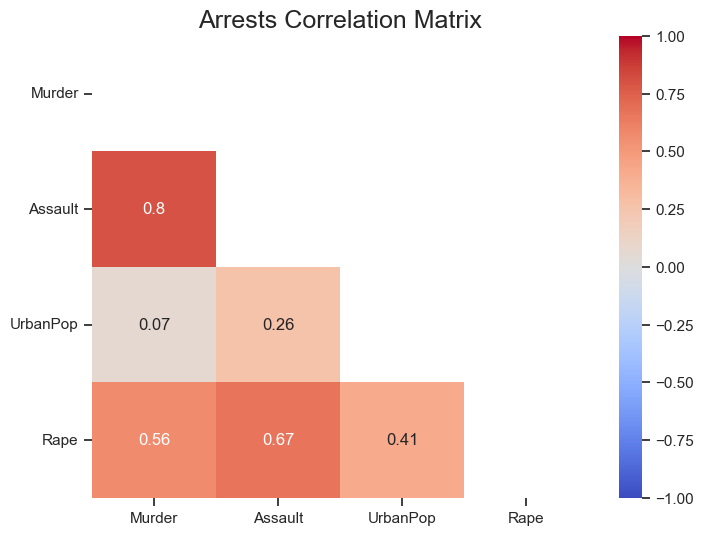

In [287]:
sns.set_theme(style="ticks")

plt.figure(figsize=(8, 6))
corr_df = arrests_df.drop(["State"], axis=1).corr()
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm", annot=True, vmin=-1, vmax=1)

# Rotate the xticks
plt.yticks(rotation=0)
# Add a title
plt.title("Arrests Correlation Matrix", size=18)
plt.show()

In [288]:
X = arrests_df.drop(["State"], axis=1).values

In [289]:
# Scale the data
X = StandardScaler().fit_transform(X)

In [290]:
pca = PCA()

In [291]:
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
df_pca.head()

,PC1,PC2,PC3,PC4
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


In [292]:
std = df_pca.describe().transpose()["std"]
for i, std in enumerate(std):
    print(f"Standard Deviation of PC{i+1}:\t{std:.2f}")


Standard Deviation of PC1:	1.59
Standard Deviation of PC2:	1.00
Standard Deviation of PC3:	0.60
Standard Deviation of PC4:	0.42


In [293]:
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Proportion of Variance Explained by PC{i+1}:\t{var:.4f}")

Proportion of Variance Explained by PC1:	0.6201
Proportion of Variance Explained by PC2:	0.2474
Proportion of Variance Explained by PC3:	0.0891
Proportion of Variance Explained by PC4:	0.0434


In [294]:
print(f"Cumulative Proportion of Variance Explained:\t{np.cumsum(pca.explained_variance_ratio_)}")

Cumulative Proportion of Variance Explained:	[0.62006039 0.86750168 0.95664248 1.        ]


In [295]:
def biplot(pca_scores, coefficients, point_labels=None, data_points=None):
    x_coordinates = pca_scores[:, 0]
    y_coordinates = pca_scores[:, 1]
    n = coefficients.shape[0]
    x_scaling = 1.0 / (x_coordinates.max() - x_coordinates.min())
    y_scaling = 1.0 / (y_coordinates.max() - y_coordinates.min())

    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(x_coordinates * x_scaling, y_coordinates * y_scaling, s=5)

    if data_points is not None:
        for i, point_label in enumerate(data_points):
            ax.annotate(
                point_label, (x_coordinates[i] * x_scaling, y_coordinates[i] * y_scaling), rotation=35
        )

    for i in range(n):
        ax.arrow(0, 0, coefficients[i, 0], coefficients[i, 1], color="r", alpha=0.5)
        if point_labels is None:
            ax.text(
                coefficients[i, 0] * 1.1,
                coefficients[i, 1] * 1.05,
                "Var" + str(i + 1),
                color="green",
                ha="center",
                va="center",
            )
        else:
            ax.text(
                coefficients[i, 0] * 1.1,
                coefficients[i, 1] * 1.05,
                point_labels[i],
                color="g",
                ha="center",
                va="center",
            )
    ax.set_xlim(None, 0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()


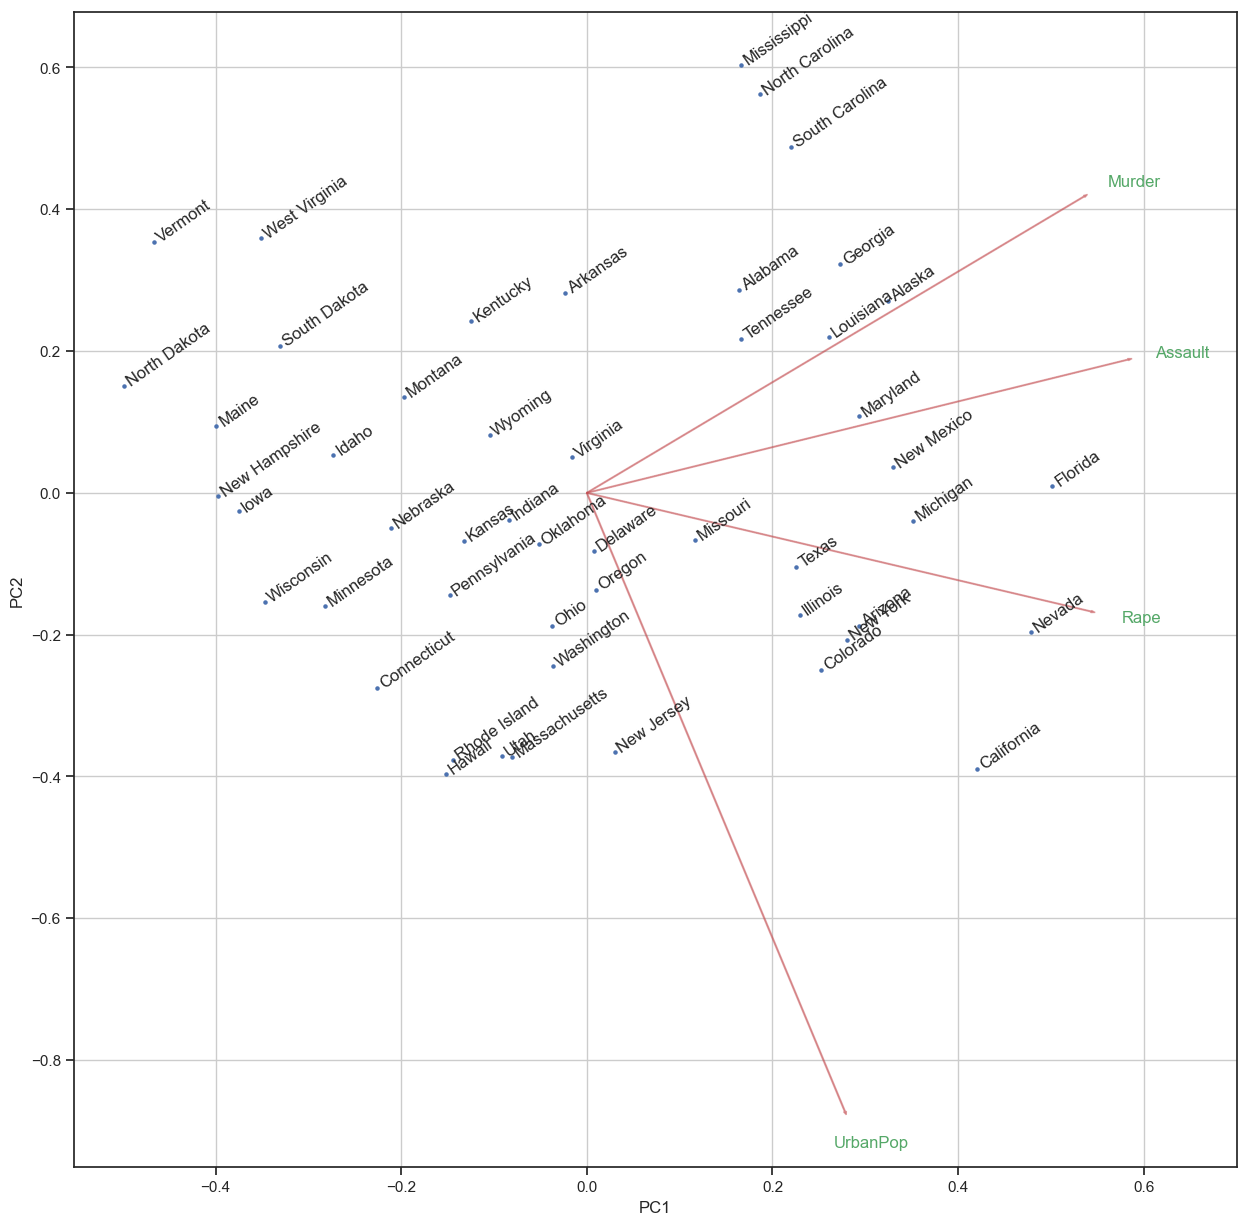

In [296]:
coefficients = np.transpose(pca.components_[0:2, :])

biplot(X_pca[:, 0:2], coefficients, point_labels=arrests_df.columns[1:], data_points=arrests_df["State"])

In [297]:
# Feature Importance
pc_1 = abs(pca.components_[0])
pc_2 = abs(pca.components_[1])

# Create a dataframe
feature_importance = pd.DataFrame(
    {"Feature": arrests_df.columns[1:], "PC1 Importance": pc_1, "PC2 Importance": pc_2}
)

feature_importance

,Feature,PC1 Importance,PC2 Importance
0,Murder,0.54,0.42
1,Assault,0.58,0.19
2,UrbanPop,0.28,0.87
3,Rape,0.54,0.17


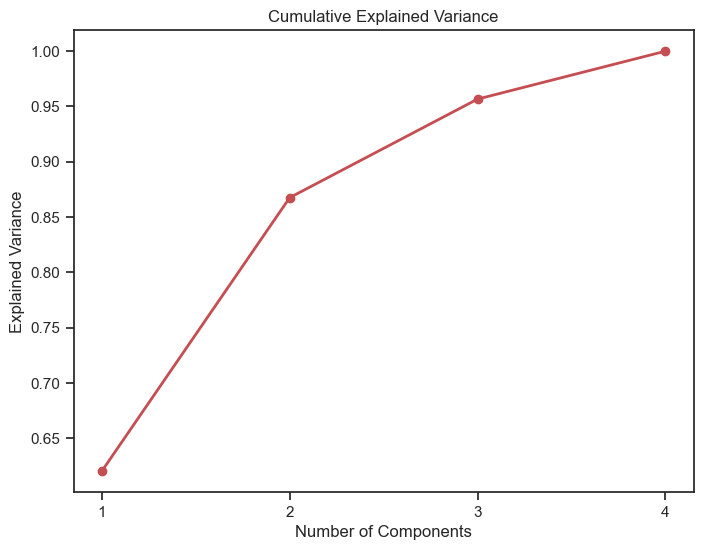

In [298]:
# Cumulative variance plot
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_),"ro-", linewidth=2)

plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.xticks(range(4), [i+1 for i in range(4)])
plt.show()

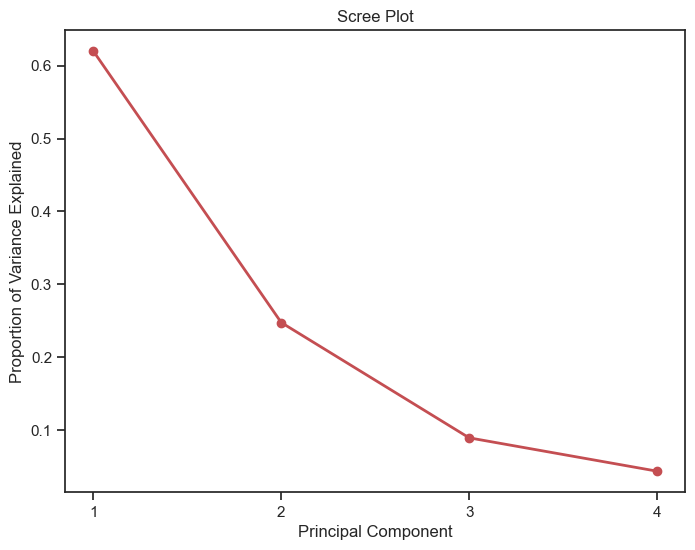

In [299]:
# Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, "ro-", linewidth=2)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.xticks(range(4), [i+1 for i in range(4)])
plt.show()

In [301]:
df_pca = pd.DataFrame(X_pca[:,:3], index=arrests_df["State"], columns=["PC1", "PC2", "PC3"])
df_pca.head()

,PC1,PC2,PC3
State,,,
Alabama,0.99,1.13,-0.44
Alaska,1.95,1.07,2.04
Arizona,1.76,-0.75,0.05
Arkansas,-0.14,1.12,0.11
California,2.52,-1.54,0.60


# Hierarchical Clustering

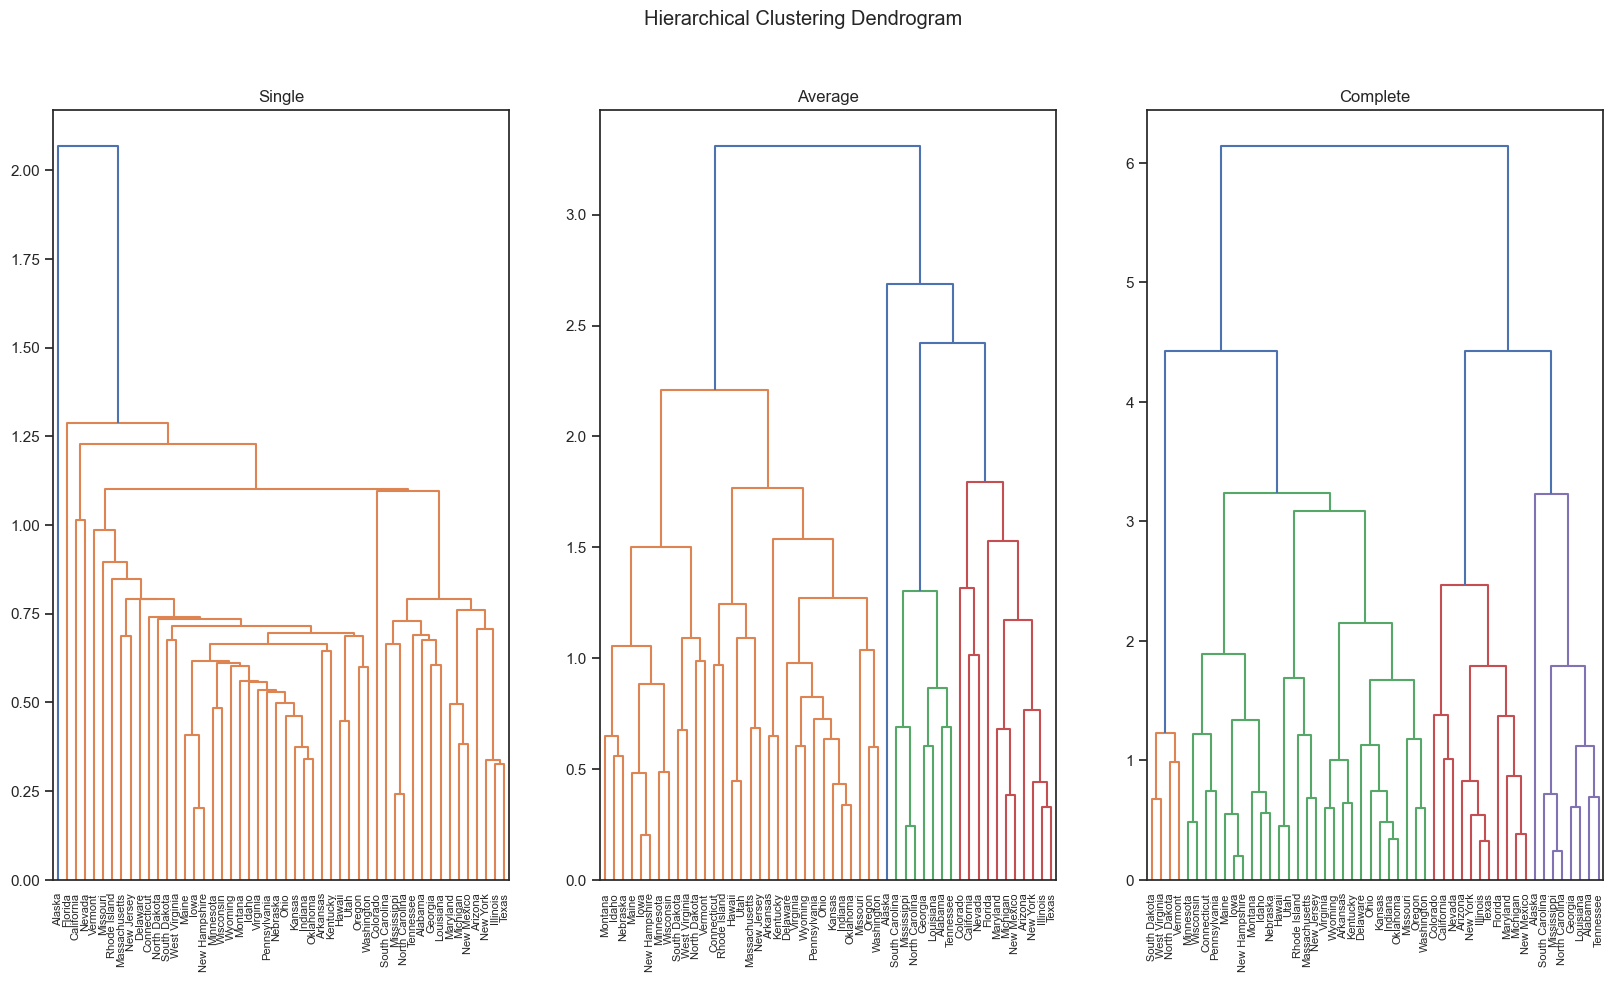

In [304]:
from tkinter import font


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df_pca)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (20,10))
fig.suptitle("Hierarchical Clustering Dendrogram", fontsize=24)
ax1.set_title("Single", fontsize=18)
dendrogram(linkage(df_pca, method="single"), labels=df_pca.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average", fontsize=18)
dendrogram(linkage(df_pca, method="average"), labels=df_pca.index, ax=ax2)
ax3.set_title("Complete", fontsize=18)
dendrogram(linkage(df_pca, method="complete"), labels=df_pca.index, ax=ax3)
plt.show()